In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv('ner_dataset.csv', encoding = 'latin1')
df = df.fillna(method = 'ffill')

In [17]:
df.describe()

,Sentence #,Word,POS,Tag
count,1048575,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 22480,the,NN,O
freq,104,52573,145807,887908


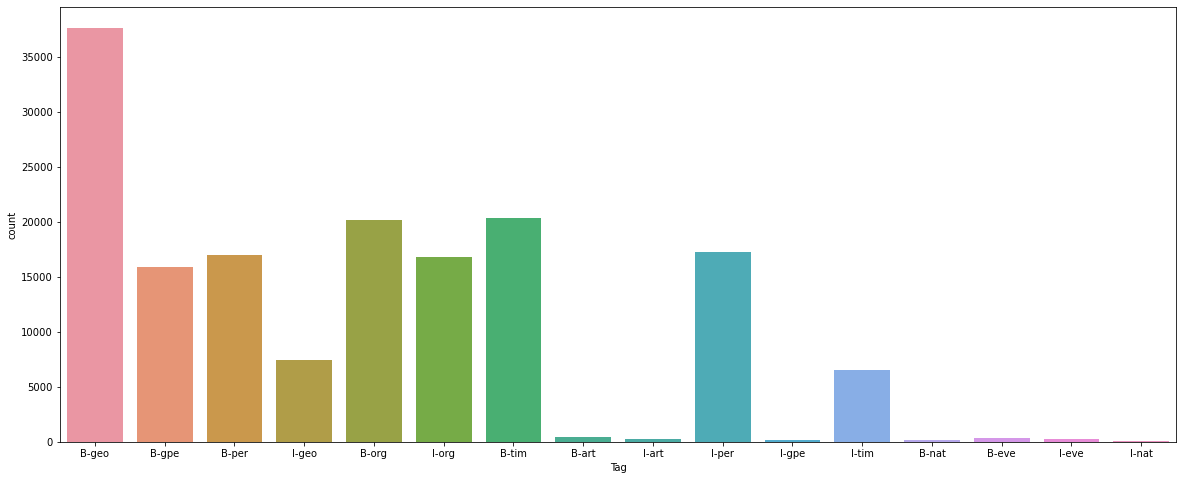

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

except_O = pd.Series(df["Tag"].loc[df["Tag"] != 'O'])

plt.figure(figsize = (20, 8))
ax = sns.countplot(x = except_O, data = df)

In [19]:
class Sentence(object):
    def __init__(self, data):
        self.data = data
        func = lambda Z: [(w ,p ,t) for w, p, t in zip(Z["Word"].values.tolist(),
                                                       Z["POS"].values.tolist(),
                                                       Z["Tag"].values.tolist())]
        self.merged = self.data.groupby('Sentence #').apply(func)
        self.sentences = [s for s in self.merged]
        
    def join(self):
        return [" ".join([s[0] for s in sentence]) for sentence in self.sentences]

In [20]:
merged_sents = Sentence(df)
merged_sents.sentences[int(np.random.choice(47958, 1))]

[('Iran', 'NNP', 'B-geo'),
 ("'s", 'POS', 'O'),
 ('air', 'NN', 'O'),
 ('force', 'NN', 'O'),
 ('also', 'RB', 'O'),
 ('has', 'VBZ', 'O'),
 ('Russian-made', 'JJ', 'O'),
 ('Sukhoi', 'NNP', 'O'),
 ('warplanes', 'NNS', 'O'),
 ('and', 'CC', 'O'),
 ('recently', 'RB', 'O'),
 ('conducted', 'VBN', 'O'),
 ('test', 'NN', 'O'),
 ('flights', 'NNS', 'O'),
 ('on', 'IN', 'O'),
 ('two', 'CD', 'O'),
 ('domestically-produced', 'JJ', 'O'),
 ('fighter', 'NN', 'O'),
 ('jets', 'NNS', 'O'),
 ('.', '.', 'O')]

In [21]:
actual_sents = merged_sents.join()
actual_sents[int(np.random.choice(47958, 1))]

'Elsewhere in the tribal region , officials said Monday that Taliban militants kidnapped and killed a pro-government tribal elder , Maulana Abdul Haleem , and dumped his body in Bajaur .'

In [22]:
uniq_words = set(df["Word"].values)
uniq_tags = set(df["Tag"].values)

word2idx = {value : key for key, value in enumerate(list(uniq_words))}
tag2idx = {value : key for key, value in enumerate(list(uniq_tags))}

In [23]:
word2idx["British"]

5693

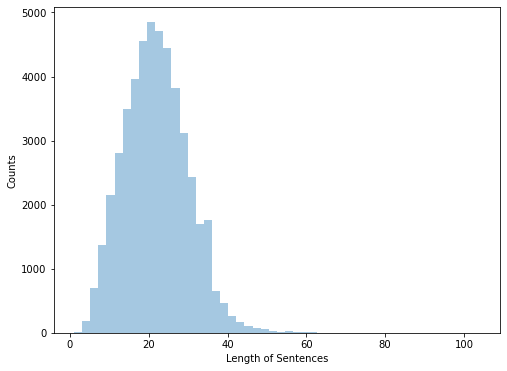

In [24]:
plt.figure(figsize = (8, 6))
plt.xlabel("Length of Sentences")
plt.ylabel("Counts")
sns.distplot([len(s) for s in merged_sents.sentences], kde = False)

In [25]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_LEN = 60

X = [[word2idx[w[0]] for w in item] for item in merged_sents.sentences]
Y = [[tag2idx[w[2]] for w in item] for item in merged_sents.sentences]
    
X = pad_sequences(maxlen = MAX_LEN, sequences = X, padding = 'post', value = len(uniq_words)-1)
Y = pad_sequences(maxlen = MAX_LEN, sequences = Y, padding = 'post', value = tag2idx['O'])
Y = [to_categorical(value, num_classes = len(uniq_tags)) for value in Y]

Using TensorFlow backend.


In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X ,Y , test_size = 0.1, random_state = 50)

In [27]:
from keras import Input, Model
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense
from keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [28]:
epochs = 5
val = (x_test, np.array(y_test))
batch_size = 64

In [29]:
history = Sequential()
shapeforinput = Input(shape = (MAX_LEN,))

history = Embedding(len(uniq_words), output_dim = MAX_LEN, input_length = MAX_LEN)(shapeforinput)
history = SpatialDropout1D(0.1)(history)
history = Bidirectional(LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.1))(history)
history = Bidirectional(LSTM(units = 64, return_sequences = True, recurrent_dropout = 0.1))(history)
output = TimeDistributed(Dense(units = len(uniq_tags), activation = 'softmax'))(history)
history = Model(shapeforinput, output)

history.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 60)            2110680   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 60)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 256)           193536    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 128)           164352    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 17)            2193      
Total params: 2,470,761
Trainable params: 2,470,761
Non-trainable params: 0
_________________________________________________

In [30]:
history.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [31]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 2,
                               mode = 'max')

callbacks = [early_stopping]

history.fit(x_train, np.array(y_train),
            epochs = epochs,
            batch_size = batch_size,
            validation_data = val,
            callbacks = callbacks,
            verbose = 1)

D:\ProgramData\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 43163 samples, validate on 4796 samples
Epoch 1/4
43163/43163 [==============================] - 322s 7ms/step - loss: 0.1910 - accuracy: 0.9578 - val_loss: 0.0792 - val_accuracy: 0.9767
Epoch 2/4
43163/43163 [==============================] - 328s 8ms/step - loss: 0.0565 - accuracy: 0.9837 - val_loss: 0.0466 - val_accuracy: 0.9867
Epoch 3/4
43163/43163 [==============================] - 337s 8ms/step - loss: 0.0381 - accuracy: 0.9889 - val_loss: 0.0417 - val_accuracy: 0.9878
Epoch 4/4
43163/43163 [==============================] - 354s 8ms/step - loss: 0.0312 - accuracy: 0.9907 - val_loss: 0.0402 - val_accuracy: 0.9884
